<a href="https://colab.research.google.com/github/Mindauskas/book_recommendations/blob/master/book_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Book recommendations**

Book-Crossings is a book ratings dataset compiled by Cai-Nicolas Ziegler based on data from bookcrossing.com. It contains 1.1 million ratings of 270,000 books by 90,000 users. The ratings are on a scale from 1 to 10, and implicit ratings are also included.
Link to the dataset: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

In [0]:
%matplotlib inline

In [2]:
try:
   %tensorflow_version 2.x
except Exception:
   pass

TensorFlow 2.x selected.


In [0]:
SETUP = True

In [4]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

     |████████████████████████████████| 296kB 5.3MB/s 
     |████████████████████████████████| 153kB 55.1MB/s 
     |████████████████████████████████| 552kB 52.9MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 122kB 56.1MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 102kB 3.2MB/s 
     |████████████████████████████████| 737kB 11.2MB/s 
     |████████████████████████████████| 1.8MB 3.5MB/s 
0.3.8
2.1.0-rc1


In [5]:
from toai.imports import *
from toai.encode import CategoricalEncoder
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the env

In [0]:
tf.get_logger().setLevel("ERROR")

In [0]:
TEMP_DIR = Path("temp/book-recommendations")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
if SETUP:
    TEMP_DIR.mkdir(parents=True, exist_ok=True)

**EDA**

In [0]:
book_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = 'latin')

In [10]:
book_ratings.shape

(1149780, 3)

In [11]:
book_ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
book_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [13]:
book_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [0]:
TARGET_COL = 'Book-Rating'

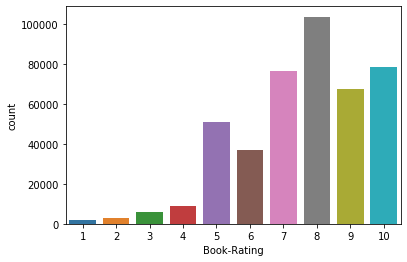

In [61]:
sns.countplot(TARGET_COL, data = book_ratings)

Drop instances with rating = 0. By definition of the dataset explicit ratings should be from 1 - 10.

In [0]:
book_ratings = book_ratings[book_ratings[TARGET_COL] != 0]

In [17]:
book_ratings.shape

(433671, 3)

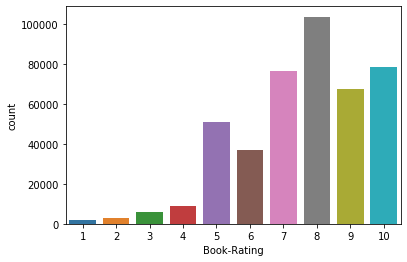

In [62]:
sns.countplot(TARGET_COL, data = book_ratings)

Number of times books were rated

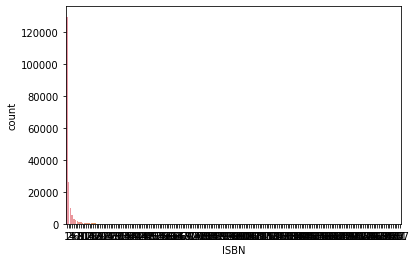

In [63]:
sns.countplot(book_ratings['ISBN'].value_counts())

Lots of books are ranked only a few times. What if I drop those rarely ranked books?

In [0]:
book_ratings['ISBN_count'] = book_ratings.groupby('ISBN')['ISBN'].transform('count')
book_ratings['user_count'] = book_ratings.groupby('User-ID')['User-ID'].transform('count')

In [21]:
book_ratings.head(10)

,User-ID,ISBN,Book-Rating,ISBN_count,user_count
1,276726,0155061224,5,1,1
3,276729,052165615X,3,1,2
4,276729,0521795028,6,1,2
6,276736,3257224281,8,4,1
7,276737,0600570967,6,1,1
8,276744,038550120X,7,81,1
9,276745,342310538,10,1,1
16,276747,0060517794,9,30,5
19,276747,0671537458,9,17,5
20,276747,0679776818,8,21,5


In [0]:
book_ratings_frequent = book_ratings[
                                     (book_ratings.ISBN_count > 10) &
                                     (book_ratings.user_count > 10)]

In [23]:
book_ratings_frequent.shape

(83550, 5)

**Split df**

In [0]:
from toai.data.utils import split_df

In [0]:
train_df, val_df, test_df = split_df(book_ratings_frequent, 0.4)

In [26]:
[x.shape for x in (train_df, val_df, test_df)]

[(50130, 5), (16710, 5), (16710, 5)]

**Preprocess**

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
encoder = CategoricalEncoder()

In [28]:
scaler.fit(train_df[[TARGET_COL]])
encoder.fit(train_df)

CategoricalEncoder(columns=None)

In [29]:
joblib.dump(scaler, TEMP_DIR / "scaler.pickle")
joblib.dump(scaler, TEMP_DIR / "encoder.pickle")

['temp/book-recommendations/encoder.pickle']

In [30]:
train_df[TARGET_COL] = scaler.transform(train_df[[TARGET_COL]])
train_df = encoder.transform(train_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50130 entries, 0 to 50129
Data columns (total 5 columns):
User-ID        50130 non-null int64
ISBN           50130 non-null int64
Book-Rating    50130 non-null int64
ISBN_count     50130 non-null int64
user_count     50130 non-null int64
dtypes: int64(5)
memory usage: 1.9 MB


In [32]:
train_df.head(5)

,User-ID,ISBN,Book-Rating,ISBN_count,user_count
0,2146,595,0,11,279
1,3770,204,0,12,87
2,4132,876,1,4,22
3,2935,488,0,116,6
4,1541,3413,0,86,18


In [0]:
val_df[TARGET_COL] = scaler.transform(val_df[[TARGET_COL]])
val_df = encoder.transform(val_df)

**Collaborative filtering**

In [0]:
n_users = train_df['User-ID'].nunique() + 100
n_books = train_df['ISBN'].nunique() + 100

In [35]:
n_users, n_books

(5994, 5043)

In [0]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
train_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df['User-ID'].values, train_df['ISBN'].astype(np.int64).values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[TARGET_COL].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
val_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (val_df['User-ID'].values, val_df['ISBN'].values)
            ),
            tf.data.Dataset.from_tensor_slices(val_df[TARGET_COL].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
train_data_steps = len(train_df) // BATCH_SIZE

In [0]:
def make_dot_model(
    user_dim, item_dim, embedding_dim,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
dot_model = make_dot_model(n_users, n_books, 128)

In [42]:
dot_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       767232      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       645504      input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [44]:
PATIENCE = 5

dot_model_history = dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=70,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)

Train for 391 steps, validate for 131 steps
Epoch 1/70
391/391 - 8s - loss: 0.2467 - mean_absolute_error: 0.4965 - val_loss: 0.2450 - val_mean_absolute_error: 0.4948
Epoch 2/70
391/391 - 6s - loss: 0.2388 - mean_absolute_error: 0.4884 - val_loss: 0.2401 - val_mean_absolute_error: 0.4897
Epoch 3/70
391/391 - 6s - loss: 0.2297 - mean_absolute_error: 0.4788 - val_loss: 0.2353 - val_mean_absolute_error: 0.4846
Epoch 4/70
391/391 - 6s - loss: 0.2193 - mean_absolute_error: 0.4676 - val_loss: 0.2306 - val_mean_absolute_error: 0.4794
Epoch 5/70
391/391 - 6s - loss: 0.2069 - mean_absolute_error: 0.4537 - val_loss: 0.2259 - val_mean_absolute_error: 0.4740
Epoch 6/70
391/391 - 6s - loss: 0.1924 - mean_absolute_error: 0.4369 - val_loss: 0.2210 - val_mean_absolute_error: 0.4683
Epoch 7/70
391/391 - 6s - loss: 0.1762 - mean_absolute_error: 0.4172 - val_loss: 0.2160 - val_mean_absolute_error: 0.4621
Epoch 8/70
391/391 - 6s - loss: 0.1589 - mean_absolute_error: 0.3950 - val_loss: 0.2109 - val_mean_abs

**Concat model**

In [0]:
def make_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
concat_model = make_concat_model(
    n_users,
    n_books,
    128,
    layer_size=256,
    dropout_rate=0.2,
    regularization=(1e-8, 1e-6),
)

In [0]:
concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [48]:
PATIENCE = 5

concat_model_history = concat_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=70,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)

Train for 391 steps, validate for 131 steps
Epoch 1/70
391/391 - 10s - loss: 0.1963 - mean_absolute_error: 0.3643 - val_loss: 0.1550 - val_mean_absolute_error: 0.3367
Epoch 2/70
391/391 - 8s - loss: 0.1301 - mean_absolute_error: 0.2475 - val_loss: 0.1387 - val_mean_absolute_error: 0.2521
Epoch 3/70
391/391 - 8s - loss: 0.1139 - mean_absolute_error: 0.2141 - val_loss: 0.1398 - val_mean_absolute_error: 0.2383
Epoch 4/70
391/391 - 9s - loss: 0.1028 - mean_absolute_error: 0.1952 - val_loss: 0.1418 - val_mean_absolute_error: 0.2366
Epoch 5/70
391/391 - 8s - loss: 0.0929 - mean_absolute_error: 0.1811 - val_loss: 0.1437 - val_mean_absolute_error: 0.2358
Epoch 6/70
391/391 - 8s - loss: 0.0872 - mean_absolute_error: 0.1724 - val_loss: 0.1443 - val_mean_absolute_error: 0.2336
Epoch 7/70
391/391 - 8s - loss: 0.0812 - mean_absolute_error: 0.1645 - val_loss: 0.1457 - val_mean_absolute_error: 0.2339
Epoch 8/70
391/391 - 8s - loss: 0.0728 - mean_absolute_error: 0.1525 - val_loss: 0.1452 - val_mean_ab

**Mean model as baseline**

In [0]:
class MeanModel(keras.Model):
    def __init__(self, mean):
        super().__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)

    def call(self, inputs):
        return tf.ones_like(inputs[0], dtype=tf.float32) * self.mean

In [0]:
mean_model = MeanModel(train_df[TARGET_COL].mean())

In [0]:
mean_model.compile(
    optimizer=keras.optimizers.Adam(3e-4), loss=keras.losses.mse,
)

**Evaluate models**

In [0]:
from toai.metrics import rmse

In [0]:
def evaluate_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))
    return metric(y_true, y_pred)

In [54]:
for model in [mean_model, dot_model, concat_model]:
    print(evaluate_predictions(model, val_dataset, scaler, rmse))

3.6848643868031377
3.603496791849922
3.34599197946469


In [0]:
test_df[TARGET_COL] = scaler.transform(test_df[[TARGET_COL]])
test_df = encoder.transform(test_df)

In [0]:
test_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (test_df['User-ID'].values, test_df['ISBN'].values)
            ),
            tf.data.Dataset.from_tensor_slices(test_df[TARGET_COL].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [57]:
for model in [mean_model, dot_model, concat_model]:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))

3.686771784398326
3.611767562236434
3.381294868959415
